<a href="https://colab.research.google.com/github/MasoudMoeini/Computer-Vison/blob/master/FinalEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolution Refinement for Enlarged Scale Images Using GANs

Recent innovations in Deep Learning (DL) and Convolutional Neural Network (CNN) in computer vision has enabled us to develop sophisticated methods to improve traditional approaches. Based on CIFAR10 dataset,I developed a novel method in order to get high resolution version of enlarged scale images from low scale images by ap- plying unsupervised deep learning approach. The idea is that based on Generative Adversarial Networks (GANs) we assume the input for network is sequences of low scale (e.g 8 x 8) and in GANs the Generator part generates some random noisy higher scale images (e.g 32 x 32) for each input image and the Discriminator based on the original low scale image detects the desired image among the generated random noisy images.


In [0]:
#starting to build GANs network
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
images=np.load('data.npy')
resized8=np.load('array8.npy')
%matplotlib inline

In [206]:
print("Training set size:\t",len(images))

Training set size:	 50000


In [207]:
images=images[:200]
resized8=resized8[:200]
print(len(images))

200


In [0]:
import tensorflow.contrib.layers as lays
def generator(input,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        net = lays.conv2d_transpose(input,16, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net,32, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net, 3, [5, 5], stride=1, padding='SAME', activation_fn=tf.nn.tanh)
        return net

In [0]:
def discriminator(input,reuse=True):
    with tf.variable_scope('dis',reuse=reuse):
        net = lays.conv2d(input, 32, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) #16 x16 x 32
        net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) # 8 x 8 x 16
        net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME',activation_fn=tf.nn.relu) #--> 2 x 2 x 8
        dim = int(np.prod(net.get_shape()[1:]))
        fc1 = tf.reshape(net, shape=[-1, dim], name='fc1')
        w2 = tf.get_variable('w2', shape=[fc1.shape[-1], 1], dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable('b2', shape=[1], dtype=tf.float32,initializer=tf.constant_initializer(0.0))
        logits = tf.add(tf.matmul(fc1, w2), b2, name='logits')
        Dis_out = tf.nn.sigmoid(logits)
        return logits

In [0]:
tf.reset_default_graph()
real_images=tf.placeholder(tf.float32, (None,32, 32, 3))
inputs_= tf.placeholder(tf.float32, (None,8, 8, 3))
G=generator(inputs_)
D_real=discriminator(real_images,reuse=None)
D_fake=discriminator(G,reuse=True)

In [0]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))
D_loss=loss_func(D_real,tf.ones_like(D_real)) #Smoothing for generalization
D_fake_loss=loss_func(D_fake,tf.zeros_like(D_real))
#D_loss=D_loss+D_fake_loss
G_loss= loss_func(D_fake,tf.ones_like(D_fake))

#D_loss=tf.reduce_mean(D_fake)-tf.reduce_mean(D_real)
#G_loss=-tf.reduce_mean(D_fake)
S_loss = tf.reduce_mean((G-real_images)**2)

In [176]:
''''
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

D_real_loss=loss_func(D_logits_real,tf.ones_like(D_logits_real)*0.9) #Smoothing for generalization
D_fake_loss=loss_func(D_logits_fake,tf.zeros_like(D_logits_real))
D_loss=D_real_loss+D_fake_loss

#G_loss= loss_func(D_logits_fake,tf.ones_like(D_logits_fake)) 
G_loss = tf.reduce_mean((G-real_images)**2)
#G_loss = tf.reduce_mean((Sr-Hr)**2)
'''

"'\ndef loss_func(logits_in,labels_in):\n    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))\n\nD_real_loss=loss_func(D_logits_real,tf.ones_like(D_logits_real)*0.9) #Smoothing for generalization\nD_fake_loss=loss_func(D_logits_fake,tf.zeros_like(D_logits_real))\nD_loss=D_real_loss+D_fake_loss\n\n#G_loss= loss_func(D_logits_fake,tf.ones_like(D_logits_fake)) \nG_loss = tf.reduce_mean((G-real_images)**2)\n#G_loss = tf.reduce_mean((Sr-Hr)**2)\n"

In [0]:
lr=0.0005 #0.0002

#Do this when multiple networks interact with each other
tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'dis' in var.name]
g_vars=[var for var in tvars if 'gen' in var.name]
GENLOSS=G_loss+S_loss
D_trainer=tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
G_trainer=tf.train.AdamOptimizer(lr).minimize(GENLOSS,var_list=g_vars) #0.001*g_loss+d_loss
#G_trainer=tf.train.AdamOptimizer(lr).minimize((0.001*G_loss+D_loss),var_list=g_vars)
batch_size=20
epochs=100
h=len(images)
init=tf.global_variables_initializer()

In [215]:
samples=[] #generator examples
Daverageloss=[]
Gaverageloss=[]
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        num_batches=h//batch_size
        print('epoch ',epoch)
        DLOSS=[]
        GLOSS=[]
        
        for i in range(num_batches):
            #m=i*batch_size
            batch_images=images[i*batch_size : (i+1)*batch_size].reshape(batch_size,32,32,3)
            batch_z=resized8[i*batch_size : (i+1)*batch_size].reshape(batch_size,8,8,3)
            Go=sess.run(generator(inputs_,reuse=True),feed_dict={inputs_:batch_z})
           # _=sess.run(D_trainer,feed_dict={real_images:batch_images,inputs_:batch_z})
           # _=sess.run(G_trainer,feed_dict={inputs_:batch_z})
            Dloss, _ = sess.run([D_loss, D_trainer], feed_dict={real_images:batch_images,G:Go})
            Genloss, _ = sess.run([GENLOSS, G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            #Genloss, _ = sess.run([G_loss, G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            DLOSS.append(Dloss)
            GLOSS.append(Genloss)
            if epoch==epochs-1:
                samples.append(Go)
            #Genloss, _ = sess.run([g_loss, train_Gen], feed_dict={Sr:G,Hr:batch_images})
            print('epoch {} batch number {}   discrim batch loss: {} Gen batch loss: {}'.format(epoch,i,Dloss,Genloss))
        MeanDloss=np.mean(DLOSS)
        MeanGlos=np.mean(GLOSS)
        Daverageloss.append(np.mean(DLOSS))
        Gaverageloss.append(MeanGlos)
        print(' Average discrim loss: {} Average Gen loss: {} '.format(MeanDloss,MeanGlos))  
       
     

epoch  0
epoch 0 batch number 0   discrim batch loss: 0.7025765180587769 Gen batch loss: 0.9428727626800537
epoch 0 batch number 1   discrim batch loss: 0.6951700448989868 Gen batch loss: 0.9360836744308472
epoch 0 batch number 2   discrim batch loss: 0.689795970916748 Gen batch loss: 0.9536745548248291
epoch 0 batch number 3   discrim batch loss: 0.687419056892395 Gen batch loss: 0.9213007688522339
epoch 0 batch number 4   discrim batch loss: 0.6844596862792969 Gen batch loss: 0.8814285397529602
epoch 0 batch number 5   discrim batch loss: 0.6792903542518616 Gen batch loss: 0.9448412656784058
epoch 0 batch number 6   discrim batch loss: 0.6746121644973755 Gen batch loss: 0.9171251058578491
epoch 0 batch number 7   discrim batch loss: 0.6669309735298157 Gen batch loss: 0.8675999045372009
epoch 0 batch number 8   discrim batch loss: 0.6631891131401062 Gen batch loss: 0.8293600678443909
epoch 0 batch number 9   discrim batch loss: 0.6506425738334656 Gen batch loss: 0.8326618671417236
 Av

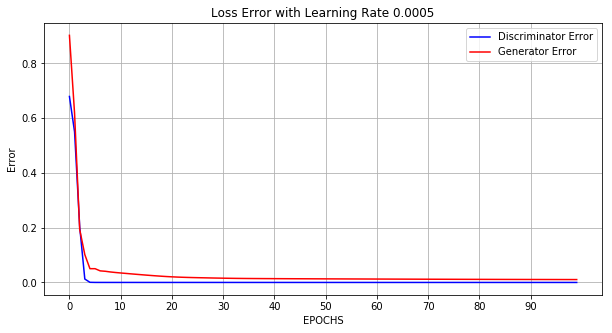

In [216]:
t=np.arange(epochs)
plt.figure(figsize=(10,5))
plt.title('Loss Error with Learning Rate {}'.format(lr))
plt.plot(t,Daverageloss,color='b',label='Discriminator Error')
plt.plot(t,Gaverageloss,color='r',label='Generator Error')
plt.xticks(np.arange(0,epochs,10))
plt.xlabel('EPOCHS')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

In [217]:
'''
H=np.reshape(samples,(batch_size*num_batches,32,32,3))
import tensorflow as tf     
y = images[:50]
y_ = H[:50]

con = tf.confusion_matrix(labels=y_, predictions=y )
sess = tf.Session()
with sess.as_default():
        print(sess.run(con))
'''

'\nH=np.reshape(samples,(batch_size*num_batches,32,32,3))\nimport tensorflow as tf     \ny = images[:50]\ny_ = H[:50]\n\ncon = tf.confusion_matrix(labels=y_, predictions=y )\nsess = tf.Session()\nwith sess.as_default():\n        print(sess.run(con))\n'

## Predicted Images 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


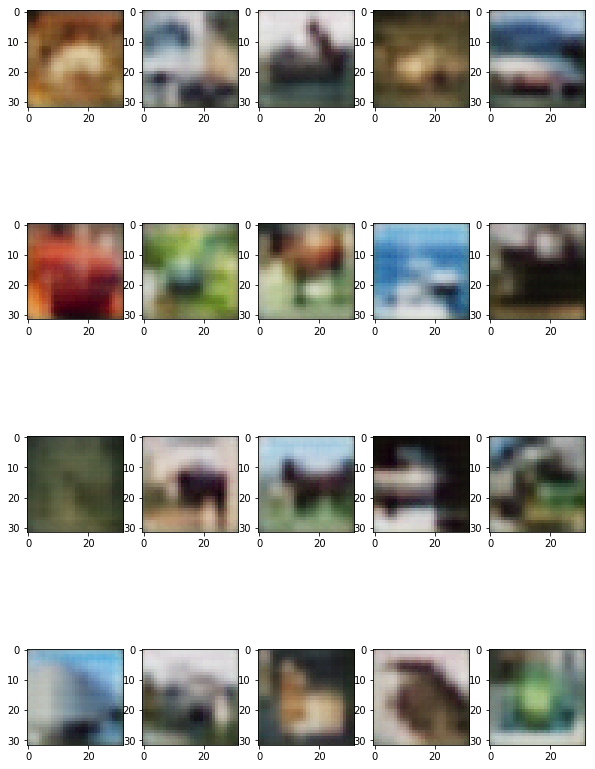

In [218]:
H=np.reshape(samples,(h,32,32,3))
fig=plt.figure(figsize=(10, 15))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=pred[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()

In [219]:
np.shape(samples)

(10, 20, 32, 32, 3)

## **Original Images From CIFAR10 dataset**

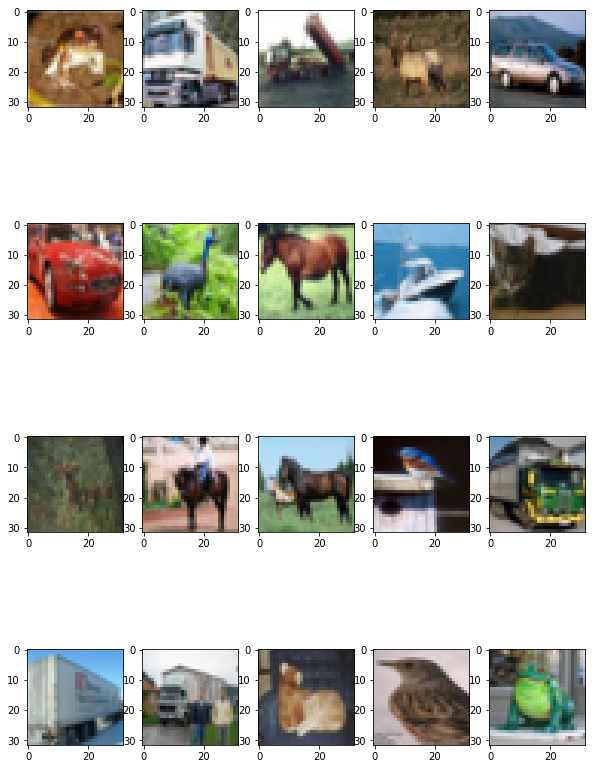

In [220]:
columns = 5
rows = 4
fig=plt.figure(figsize=(10,15))
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=images[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()